<a href="https://colab.research.google.com/github/softmurata/promptparty/blob/main/evaluation/evaluationGAIsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers accelerate bitsandbytes diffusers

In [37]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.8 MB/s eta 0:00:00


In [ ]:
!wget https://img.freepik.com/free-photo/picture-frame-on-a-wall-with-scandinavian-home-interior_53876-139779.jpg -O /content/room001.jpg

In [ ]:
!wget https://img.freepik.com/free-psd/modern-interior-design-living-room_176382-1266.jpg -O /content/room002.jpg
!wget https://img.freepik.com/premium-photo/living-room-with-white-couch-coffee-table-with-white-rug-floor_784625-7082.jpg -O /content/room003.jpg
!wget https://img.freepik.com/free-photo/modern-living-room-interior-design_23-2150794674.jpg -O /content/room004.jpg
!wget https://img.freepik.com/premium-photo/living-room-with-large-plant-white-pot_784625-7578.jpg -O /content/room005.jpg

In [ ]:
# /usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py

# 1085, 1086
# after changing, please restart
"""
# class_queries_logits = outputs.class_queries_logits  # [batch_size, num_queries, num_classes+1]
# masks_queries_logits = outputs.masks_queries_logits  # [batch_size, num_queries, height, width]
class_queries_logits = outputs.transformer_decoder_class_predictions
masks_queries_logits = outputs.transformer_decoder_mask_predictions
"""

Oneformer inference

In [1]:
import torch
import os
from PIL import Image
import numpy as np
import cv2
from transformers import OneFormerProcessor, OneFormerModel
from torch import autocast
import json
import subprocess

In [2]:
object_images_dir = "/content/objects"
os.makedirs(object_images_dir, exist_ok=True)

In [3]:
# load oneformer model
model_id = "shi-labs/oneformer_ade20k_swin_large"
processor = OneFormerProcessor.from_pretrained(model_id)
model = OneFormerModel.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:427: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [4]:
target_categories = ["sofa", "table", "cushion", "rug", "chair"]
sub_categories = ["plant", "painting", "vase"]

color_list = [
    [255, 0, 0],     # 赤
    [0, 255, 0],     # 緑
    [0, 0, 255],     # 青
    [255, 255, 0],   # イエロー
    [255, 0, 255],   # マゼンタ
    [0, 255, 255],   # シアン
    [128, 0, 128],   # パープル
    [128, 128, 128], # グレー
    [0, 128, 0],     # オリーブ
    [128, 0, 0]      # マルーン
]

color_dict = {}
for idx, t in enumerate(target_categories):
  color_dict[t] = color_list[idx]

def calculate_bounding_box(mask_image):
    # Find the indices of non-zero pixels within the mask image
    non_zero_pixels = np.transpose(np.nonzero(mask_image))

    if non_zero_pixels.size == 0:
        # Return an empty Bounding Box if there are no non-zero pixels in the mask
        return None

    # Get x and y coordinates
    x_coords, y_coords = non_zero_pixels[:, 0], non_zero_pixels[:, 1]

    # Calculate the Bounding Box coordinates
    min_x, min_y = np.min(x_coords), np.min(y_coords)
    max_x, max_y = np.max(x_coords), np.max(y_coords)

    return (min_x, min_y, max_x, max_y)

In [5]:
def get_mask(label_name):
  img_path = f"/content/{label_name}.jpg"
  image = Image.open(img_path)

  inputs = processor(image, ["semantic"], return_tensors="pt")

  with torch.no_grad():
      outputs = model(**inputs)

  # you can pass them to processor for semantic postprocessing
  predicted_semantic_map = processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]]
  )[0]

  # print(np.unique(predicted_semantic_map))

  item_list = model.config.label2id.keys()
  include_categories = {}
  include_categories["target"] = [model.config.label2id[item] for item in item_list if any(target in item for target in target_categories)]
  include_categories["sub"] = [model.config.label2id[item] for item in item_list if any(target in item for target in sub_categories)]

  # print(include_categories)

  target_base_mask = np.zeros_like(predicted_semantic_map)
  total_count = np.prod(target_base_mask.shape)
  source_image = cv2.imread(img_path)
  bh, bw = source_image.shape[:2]
  bg_image = np.zeros_like(source_image)

  subprocess.call(f"rm -rf {object_images_dir}/target", shell=True)
  os.makedirs(object_images_dir + "/target", exist_ok=True)

  label_dict = {}

  result_dict = {}

  for target_id in include_categories["target"]:
    label_pred_map = np.where(predicted_semantic_map == target_id, 255, 0)
    # bboxのリストと領域の計算
    count = np.count_nonzero(label_pred_map == 255)
    if count > 0:
      bounding_box = calculate_bounding_box(label_pred_map)  # xmin, ymin, xmax, ymax
      mask_ratio = count / total_count
      ymin, xmin, ymax, xmax = bounding_box

      label = model.config.id2label[target_id].split(",")[0].replace(" ", "")
      if label in label_dict.keys():
        label_dict[label] += 1
      else:
        label_dict[label] = 0

      target_color = None
      for cl in color_dict.keys():
        if cl in label:
          target_color = color_dict[cl]

      if target_color is not None:
        center = [int(xmin * 0.5 + xmax * 0.5), int(ymin * 0.5 + ymax * 0.5)]
        cv2.circle(bg_image,
              center=(center[0], center[1]),
              radius=20,
              color=(target_color[0], target_color[1], target_color[2]),
              thickness=-1,
              lineType=cv2.LINE_4,
              shift=0)

        item_dict = {
          "bbox": [float(xmin / bw), float(ymin / bh), float(xmax / bw), float(ymax / bh)],
          "ratio": float(mask_ratio),
          "graph": {
              "label": label,
              "color": target_color,
              "center": [float(center[0] / bh), float(center[1] / bw)]
          },
          "height": int(bh),
          "width": int(bw)
        }

      result_dict[label] = item_dict

      target_image = source_image[ymin:ymax, xmin:xmax, :]
      cv2.imwrite(object_images_dir + f"/target/{label}_{label_dict[label]}.jpg", target_image)


    target_base_mask += label_pred_map


  cv2.imwrite(f"/content/{label_name}_graph.jpg", bg_image)
  json.dump(result_dict, open(f"/content/{label_name}.json", "w"))
  display(Image.fromarray(target_base_mask.astype(np.uint8)))
  display(Image.fromarray(bg_image))

  sub_base_mask = np.zeros_like(predicted_semantic_map)
  subprocess.call(f"rm -rf {object_images_dir}/sub", shell=True)
  os.makedirs(object_images_dir + "/sub", exist_ok=True)
  label_dict = {}
  for sub_id in include_categories["sub"]:
    label_pred_map = np.where(predicted_semantic_map == sub_id, 255, 0)
    count = np.count_nonzero(label_pred_map == 255)
    if count > 0:
      bounding_box = calculate_bounding_box(label_pred_map)  # xmin, ymin, xmax, ymax
      print(count / total_count, bounding_box)
      mask_ratio = count / total_count
      ymin, xmin, ymax, xmax = bounding_box

      label = model.config.id2label[sub_id].split(",")[0].replace(" ", "")
      if label in label_dict.keys():
        label_dict[label] += 1
      else:
        label_dict[label] = 0

      target_image = source_image[ymin:ymax, xmin:xmax, :]
      cv2.imwrite(object_images_dir + f"/sub/{label}_{label_dict[label]}.jpg", target_image)
    sub_base_mask += label_pred_map

  display(Image.fromarray(sub_base_mask.astype(np.uint8)))




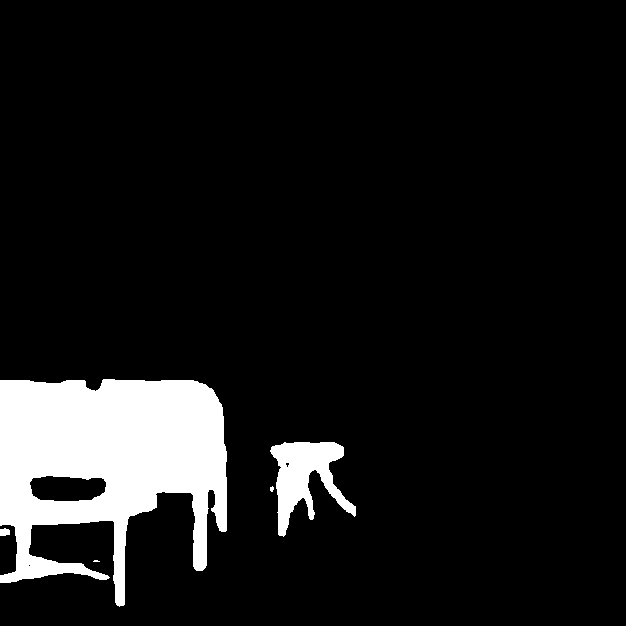

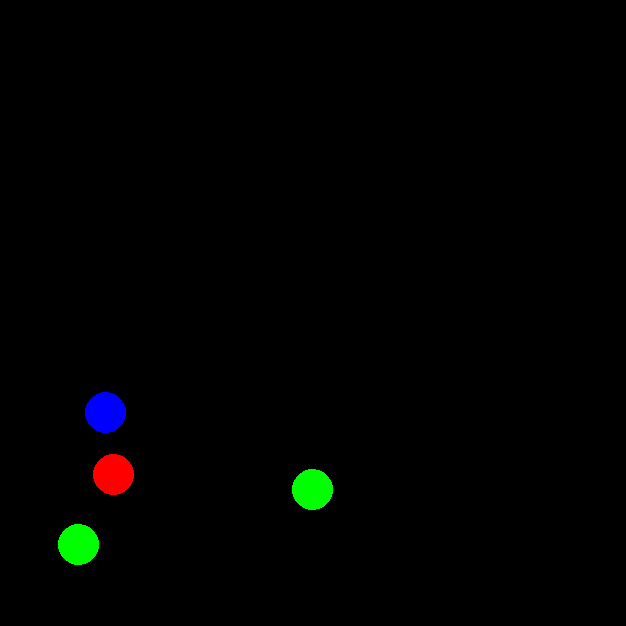

0.06129489940695526 (204, 304, 440, 472)


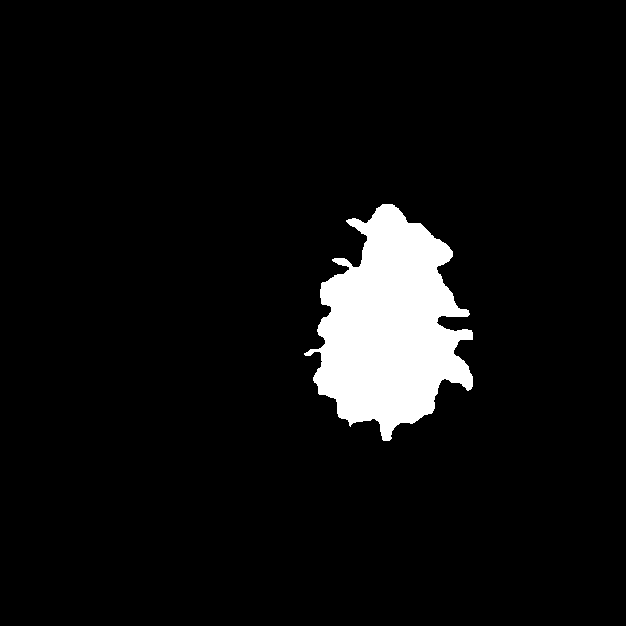

In [10]:
label_name = "room005"
get_mask(label_name)

Create network similarity score

In [26]:
import json

from sklearn.metrics.pairwise import cosine_similarity

def calculate_dist_matrix(label_name):
  result_dict = json.load(open(f"/content/{label_name}.json"))

  point_dict = {}
  for key in target_categories:
    if key in result_dict.keys():
      point_dict[key] = result_dict[key]["graph"]['center']
    else:
      point_dict[key] = [1, 1]


  distance_dict = {}
  dist_matrix = []
  for key in target_categories:
    distances = []
    for ki in target_categories:
      dis = np.sqrt((point_dict[key][0] - point_dict[ki][0]) ** 2 + (point_dict[key][1] - point_dict[ki][1]) ** 2)
      distances.append(dis)

    if len(distances) <= 10:
      pad_dis = [0 for _ in range(10 - len(distances))]
      distances.extend(pad_dis)

    distance_dict[key] = distances
    dist_matrix.append(distances)

  return dist_matrix

In [27]:
label_names = [
    "room001","room002", "room003", "room004", "room005"
]

label_dist_matrix_dict = {}

for lname in label_names:
  label_dist_matrix_dict[lname] = calculate_dist_matrix(lname)

In [ ]:
# similarities = cosine_similarity(label_dist_matrix_dict["room001"], label_dist_matrix_dict["room002"])
# print(similarities)

from scipy.spatial import distance

cs_list = []
source_name = "room001"
for target_name in ["room002", "room003", "room004", "room005"]:
  v = 1 - distance.cosine(np.array(label_dist_matrix_dict[source_name]).reshape(-1), np.array(label_dist_matrix_dict[target_name]).reshape(-1))
  cs_list.append(v)

normalize_cs_list = [(c - min(cs_list))/(max(cs_list) - min(cs_list)) for c in cs_list]
mix_cs_list = [0.2 * ncs + 0.8 * cs for ncs, cs in zip(normalize_cs_list, cs_list)]
print(mix_cs_list)

Create Object similarity score

In [38]:
# get object image

In [49]:
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
transform = [
    A.Resize(256,256,p=1),
    ToTensorV2(p=1.0)
]
transform_infer = A.Compose(transform)
effnet = timm.create_model('efficientnetv2_s')

In [55]:
def get_item_features(label_name):
  object_image_dict = {}
  result_dict = json.load(open(f"/content/{label_name}.json"))
  base_img = cv2.imread(f"/content/{label_name}.jpg")

  bh, bw = base_img.shape[:2]

  for key in target_categories:
    if key in result_dict.keys():
      value = result_dict[key]
      bbox = value['bbox']
      xmin, ymin, xmax, ymax = int(bbox[0] * bw), int(bbox[1] * bh), int(bbox[2] * bw), int(bbox[3] * bh)
      crop_img = base_img[ymin:ymax, xmin:xmax, :]
      object_image_dict[key] = crop_img
    else:
      object_image_dict[key] = np.zeros((256, 256, 3))


  features_dict = {}
  for key in object_image_dict.keys():
    input_img = object_image_dict[key]
    img = input_img[:, :, ::-1].astype(np.float32)
    input_img = transform_infer(image=img)["image"]
    features = effnet.forward_features(input_img.unsqueeze(0))
    features = features.detach().cpu().view(-1).numpy()
    features_dict[key] = features

  return features_dict

In [63]:
label_names = [
    "room001", "room002", "room003", "room004", "room005"
]

label_feature_dict = {}
for lname in label_names:
  fe_dict = get_item_features(lname)
  label_feature_dict[lname] = fe_dict

In [99]:
cs_list = []

source_name = "room001"
for target_name in ["room002", "room003", "room004", "room005"]:

  source_feature_dict = label_feature_dict[source_name]
  target_feature_dict = label_feature_dict[target_name]

  cos_sim_value = 0

  for key in target_feature_dict.keys():
    cs = 1 - distance.cosine(source_feature_dict[key], target_feature_dict[key])
    cos_sim_value += cs

  v = cos_sim_value / len(target_feature_dict.keys())
  cs_list.append(v)

normalize_cs_list = [(c - min(cs_list))/(max(cs_list) - min(cs_list)) for c in cs_list]
mix_cs_list = [0.2 * ncs + 0.8 * cs for ncs, cs in zip(normalize_cs_list, cs_list)]
print(mix_cs_list)

[0.2726347269151851, 0.2519580855965614, 0.2821250236039688, 0.8361088559031487]


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Create segmentation similarity score

In [78]:
def get_segmentation_score(label_name):
  segmentation_ratio_dict = {}
  result_dict = json.load(open(f"/content/{label_name}.json"))
  for key in target_categories:
    if key in result_dict.keys():
      mask_ratio = result_dict[key]["ratio"]
      segmentation_ratio_dict[key] = [mask_ratio]
    else:
      segmentation_ratio_dict[key] = [0]

  return segmentation_ratio_dict

In [79]:
label_segmentation_ratio_dict = {}

for lname in label_names:
  label_segmentation_ratio_dict[lname] = get_segmentation_score(lname)

In [105]:
cs_list = []

source_name = "room001"
for target_name in ["room002", "room003", "room004", "room005"]:
  cos_sim_value = 0

  source_segmentation_ratio_dict = label_segmentation_ratio_dict[source_name]
  target_segmentation_ratio_dict = label_segmentation_ratio_dict[target_name]

  for key in target_segmentation_ratio_dict.keys():
    cs = abs(source_segmentation_ratio_dict[key][0] - target_segmentation_ratio_dict[key][0])
    cos_sim_value += cs

  v = 1 - cos_sim_value / len(target_segmentation_ratio_dict.keys())
  cs_list.append(v)

normalize_cs_list = [(c - min(cs_list))/(max(cs_list) - min(cs_list)) for c in cs_list]
mix_cs_list = [0.2 * ncs + 0.8 * cs for ncs, cs in zip(normalize_cs_list, cs_list)]
print(mix_cs_list)

[0.9807990725372278, 0.9055899643359138, 0.9875023942507337, 0.7821765280668116]


Create beautify score

In [106]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [107]:
selected_model = 'koniq' #@param ['spaq', 'koniq', 'paq2piq', 'ava']

NAME_TO_HANDLE = {
    # Model trained on SPAQ dataset: https://github.com/h4nwei/SPAQ
    'spaq': 'https://tfhub.dev/google/musiq/spaq/1',

    # Model trained on KonIQ-10K dataset: http://database.mmsp-kn.de/koniq-10k-database.html
    'koniq': 'https://tfhub.dev/google/musiq/koniq-10k/1',

    # Model trained on PaQ2PiQ dataset: https://github.com/baidut/PaQ-2-PiQ
    'paq2piq': 'https://tfhub.dev/google/musiq/paq2piq/1',

    # Model trained on AVA dataset: https://ieeexplore.ieee.org/document/6247954
    'ava': 'https://tfhub.dev/google/musiq/ava/1',
}

model_handle = NAME_TO_HANDLE[selected_model]
beautify_model = hub.load(model_handle)
predict_fn = beautify_model.signatures['serving_default']

print(f'loaded model {selected_model} ({model_handle})')

loaded model koniq (https://tfhub.dev/google/musiq/koniq-10k/1)


In [112]:
import io

file_path = "/content/room001.jpg"
img = Image.open(file_path, mode='r')
resized_img = img  # .resize((1024, 1024))  # 32x32に変形

image_bytes = io.BytesIO()
resized_img.save(image_bytes, format='PNG')
image_bytes = image_bytes.getvalue()  # これが bytes

prediction = predict_fn(tf.constant(image_bytes))
beautify_score = prediction["output_0"].numpy() / 100
print("beautify score: ", beautify_score)

predicted MOS:  0.7462981414794921


Calculate Unsemble score

In [ ]:
# network similarity score + object similarity score + segmentation score + beautify score